## Week 3 homework

Given a dataset with time series data containing an event, use a linear regression to test whether there was a discontinuity in the data at the event. Consider the possibility, first, of a discontinuity only in the value of the variable but not the derivative. Then consider that there may be a discontinuity in the first derivative (the slope).  

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(42)

In [2]:
# read in dataframes
df_1 = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\2025-summer-mod-6\homework_3.1.csv')
df_2 = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\2025-summer-mod-6\homework_3.2.a.csv')
df_3 = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\2025-summer-mod-6\homework_3.2.b.csv')

# drop unnamed columns from dataframes
df_1 = df_1.drop(columns='Unnamed: 0')
df_2 = df_2.drop(columns='Unnamed: 0')
df_3 = df_3.drop(columns='Unnamed: 0')

In [3]:
df_1.head()

,time,value1,value2,value3
0,0,1.764052,1.883151,-0.369182
1,1,0.420157,-1.327759,-0.219379
2,2,1.018738,-1.230485,1.139660
3,3,2.300893,1.029397,0.715264
4,4,1.947558,-1.093123,0.720132


Text(0.5, 0, 'Time')

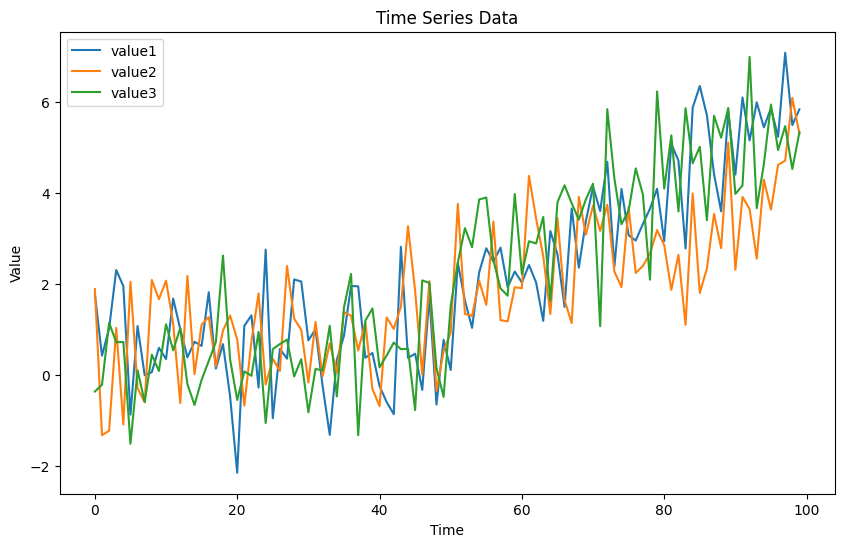

In [4]:
# Plot the data
plt.figure(figsize=(10,6))
for col in df_1.columns:
    if col.startswith('value'):
        sns.lineplot(data=df_1, x='time', y=col, label=col)
plt.title('Time Series Data')
plt.ylabel('Value')
plt.xlabel('Time')

### Event Studies

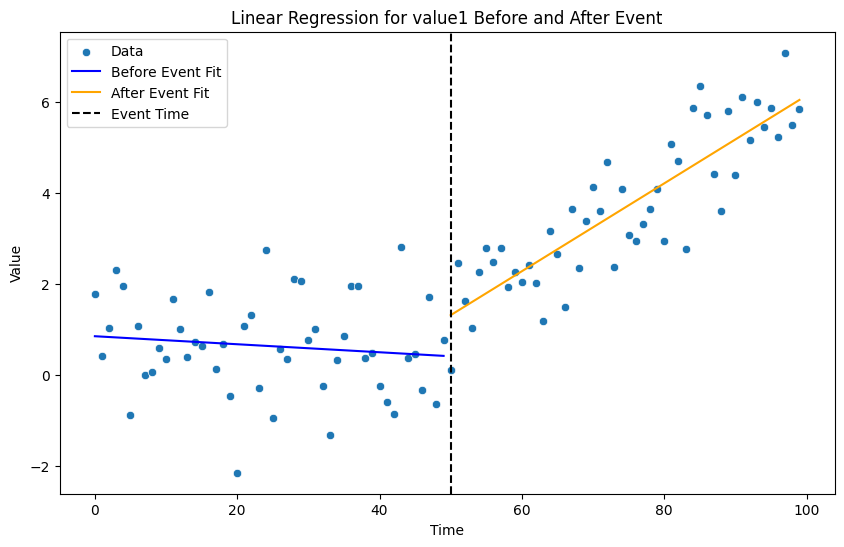

Slope difference for value1: 0.10532461852734992


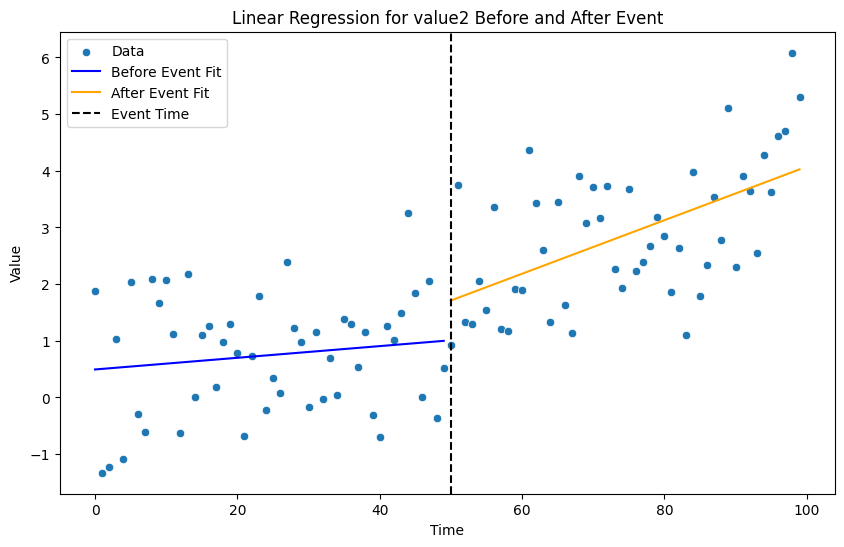

Slope difference for value2: 0.036921370621806934


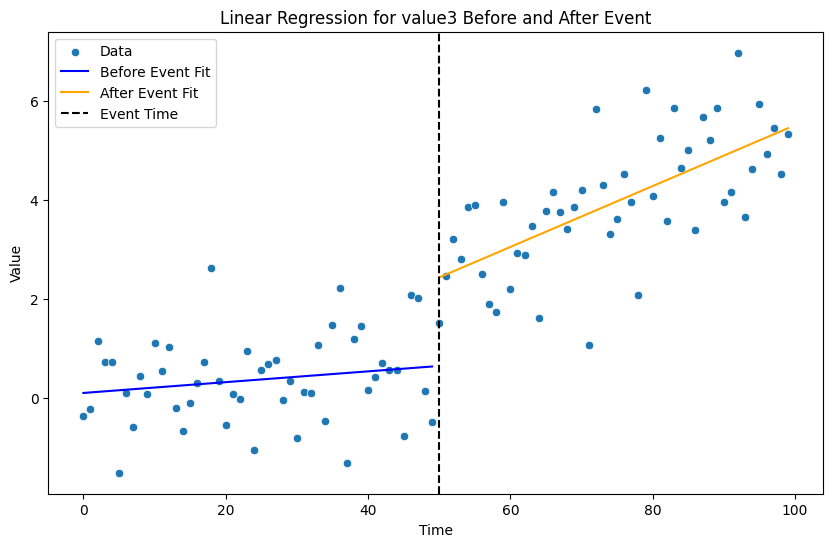

Slope difference for value3: 0.0506950767026202


In [5]:
# Split the data based on the event at time=50
df_1_before = df_1[df_1['time'] < 50]
df_1_after = df_1[df_1['time'] >= 50]
event_time = 50

# Fit a linear regression to each value column before and after the event
for col in df_1.columns:
    if col.startswith('value'):
        # Fit model before the event
        X_before = sm.add_constant(df_1_before['time'])
        y_before = df_1_before[col]
        model_before = sm.OLS(y_before, X_before).fit()
        y_before_pred = model_before.predict(X_before)

        # Fit model after the event
        X_after = sm.add_constant(df_1_after['time'])
        y_after = df_1_after[col]
        model_after = sm.OLS(y_after, X_after).fit()
        y_after_pred = model_after.predict(X_after)

        # Plot the regression lines and the data
        plt.figure(figsize=(10,6))
        sns.scatterplot(data=df_1, x='time', y=col, label='Data')
        sns.lineplot(data=df_1_before, x='time', y=y_before_pred, label='Before Event Fit', color='Blue')
        sns.lineplot(data=df_1_after, x='time', y=y_after_pred, label='After Event Fit', color='Orange')
        plt.axvline(event_time, color='black', linestyle='--', label='Event Time')
        plt.title(f'Linear Regression for {col} Before and After Event')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        # Calcualte the differences in slopes
        slope_before = model_before.params['time']
        slope_after = model_after.params['time']
        slope_difference = slope_after-slope_before
        print(f"Slope difference for {col}: {slope_difference}")

### Differences in Defferences

In [6]:
df_2.head()

,group1,time1,outcome1
0,0,0,0.882026
1,0,1,1.600079
2,0,0,0.489369
3,0,1,2.520447
4,0,0,0.933779


In [7]:
df_3.head()

,group2,time2,outcome2
0,0,0,0.667155
1,0,1,2.470969
2,0,0,-0.506778
3,0,1,1.525657
4,0,0,0.273664


In [8]:
import statsmodels.formula.api as smf

# For df_2
# 'group' (0=control, 1=treated), 'time' (0=pre, 1=post), 'value'
model_2 = smf.ols('outcome1 ~ group1 + time1 + group1:time1', data=df_2).fit()
print(model_2.summary())

# For df_3
model_3 = smf.ols('outcome2 ~ group2 + time2 + group2:time2', data=df_3).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:               outcome1   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     2964.
Date:                Tue, 03 Jun 2025   Prob (F-statistic):               0.00
Time:                        12:49:55   Log-Likelihood:                -712.28
No. Observations:                1000   AIC:                             1433.
Df Residuals:                     996   BIC:                             1452.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0258      0.031     -0.829   

In [9]:
effect_2 = model_2.params['group1:time1']
effect_3 = model_3.params['group2:time2']

print(f"Estimated effect for df_2: {effect_2}")
print(f"Estimated effect for df_3: {effect_3}")

Estimated effect for df_2: 0.6858469689928723
Estimated effect for df_3: 1.349858924693982


In [10]:
# Get the t-statistics and p-values for the treatment effect in both models
t_2 = model_2.tvalues['group1:time1']
p_2 = model_2.pvalues['group1:time1']

t_3 = model_3.tvalues['group2:time2']
p_3 = model_3.pvalues['group2:time2']

print(f"df_2: t-stat = {t_2:.3f}, p-value = {p_2:.3g}")
print(f"df_3: t-stat = {t_3:.3f}, p-value = {p_3:.3g}")

# Compare significance
if p_2 < p_3:
    print("df_2 has the most statistically significant treatment effect.")
else:
    print("df_3 has the most statistically significant treatment effect.")

df_2: t-stat = 10.970, p-value = 1.64e-26
df_3: t-stat = 9.180, p-value = 2.43e-19
df_2 has the most statistically significant treatment effect.
